# apply_UNET ##

In this notebook we apply the previously trained model to a set of images.

This includes the following steps:
* build the network and weights 
* load the dataset and apply the train/test split
* prerpocess the dataset (zero center, normalize to range -1 to 1)
* feed the data to the model
* display the prediction ( same shape as input image)

## Setup

In [1]:
!ls includes

TimeIt.py     __pycache__  playgroundDataGenerator.py
UNETmodel.py  focal.py	   playgroundUNET.py


In [2]:
!ls /tf/results/models/

Unet_0-0-0.h5		       Unet_0-0-4_20200423-075700.h5
Unet_0-0-0_20200411-124102.h5  Unet_0-0-4_20200423-093523.h5
Unet_0-0-1.h5		       Unet_0-0-5_fl_RAda,_20200507-094138.h5
Unet_0-0-1_20200411-120615.h5  Unet_0-0-5_fl_RAdam_20200426-134706.h5
Unet_0-0-1_20200411-122810.h5  Unet_0-0-5_fl_RAdam_20200512-094113.h5
Unet_0-0-1_20200411-132132.h5  Unet_0-0-5_fl_RAdam_20200522-122844.h5
Unet_0-0-1_20200413-105017.h5  Unet_0-0-5_fl_RAdam_20200525-084831.h5
Unet_0-0-2_20200413-190741.h5  Unet_0-0-5_fl_RAdam_20200602-100339.h5
Unet_0-0-3_20200414-144612.h5  Unet_0-0-5_fl_RAdam_20200602-115253.h5
Unet_0-0-4_20200423-064224.h5  Unet_0-0-5_fl_RAdam_20200603-153056.h5
Unet_0-0-4_20200423-070809.h5  Unet_0-0-5_fl_RAdam_20200610-140630.h5
Unet_0-0-4_20200423-070930.h5  Unet_0-0-5_fl_RAdam_20200610-141144.h5
Unet_0-0-4_20200423-071031.h5  Unet_0-0-5_fl_RAdam_20200615-152004.h5
Unet_0-0-4_20200423-071209.h5  Unet_0-0-5_fl_RAdam_20200615-191423.h5
Unet_0-0-4_20200423-071259.h5  Unet_0-0-5_fl_RAdam_20200

In [3]:
## load the UNet model from UNETmodel.py
# details the the network can be found here: 
from includes.UNETmodel import UNet
import tensorflow as tf


# create model takes three arguments
#   the dimension of the input image (width x height x channels)
#   the number of classes 
#   the number of convolution kernels (default 32)

# 
# first try model (slow)
#unet = UNet().create_model((540,300,1),1, d=32)
#unet.load_weights("/tf/results/models/Unet_0-0-1_20200413-105017.h5")

# shallow model (faster)
unet = UNet().create_model((100,100,1),1, d=8)
unet.load_weights("/tf/results/models/Unet_0-0-5_fl_RAdam_20200610-141144.h5")

build UNet ...


In [4]:
import clickpoints
import numpy as np
data = []
for i in [1]:
    path = "/tf/data/aperture8/cell_%d/Cell%d.cdb"%(i,i)
    print(path)
    cdb = clickpoints.DataFile(path, "r")
    positions = np.array([[e.x, e.y, e.image.sort_index] for e in cdb.getEllipses()])
    big_list = []
    for im in cdb.getImages():
        small_list = []
        for x,y,t in positions:
            small_list.append(im.data[int(y-50):int(y+50),
                                  int(x-50):int(x+50)])
        big_list.append(small_list)
    data.append(big_list)
data=np.array(data)[0]

no openslide found
/tf/data/aperture8/cell_1/Cell1.cdb
path /tf/data/aperture8/cell_1/Cell1.cdb
Open database with version 22


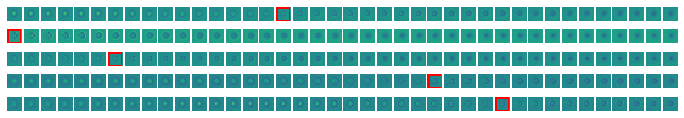

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
dataP = data[::1]
#fig = plt.figure()
fig, axes = plt.subplots(ncols=dataP.shape[0], nrows=dataP.shape[1], figsize=(12,2))
axes = np.array(axes).reshape((dataP.shape[1], dataP.shape[0])).T
for i in range(dataP.shape[1]):
    for j in range(dataP.shape[0]):
        #ax = plt.subplot(data.shape[1]//4, data.shape[0], i*data.shape[0]+j+1)
        #ax.imshow(data[j,i])
        ax =axes[j][i]
        ax.imshow(dataP[j,i], vmin=0, vmax=255)
        ax.axis("off")
for i,p in enumerate(positions[:,2]):
    ax = axes[int(p),i]
    rect = Rectangle((0,0), 100, 100, edgecolor="r", linewidth=3, facecolor="none")
    ax.add_patch(rect)
#plt.savefig("cellFocusInput.pdf")

In [6]:
dataN = (data-data.mean((2,3))[:,:,None,None])/data.std((2,3))[:,:,None,None]
predictions = []
for d in dataN.reshape((-1, 100,100)):
    predictions.append(unet.predict(d[None,:,:,None]))
predictions=np.array(predictions).squeeze().reshape((40,5,100,100))

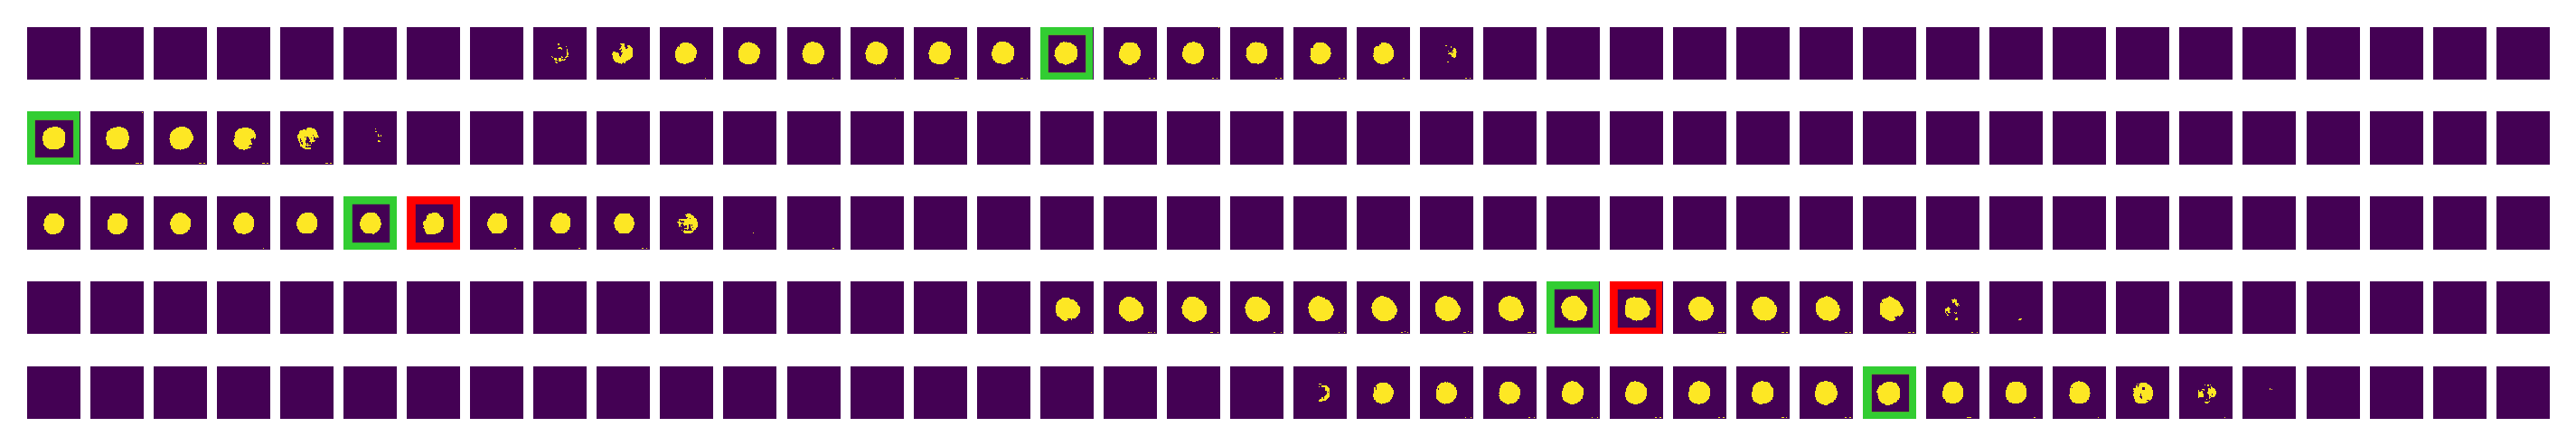

In [7]:
import matplotlib.pyplot as plt
dataP = predictions[::1]
#fig = plt.figure()
fig, axes = plt.subplots(ncols=dataP.shape[0], nrows=dataP.shape[1], figsize=(12,2), dpi=300)
axes = np.array(axes).reshape((dataP.shape[1], dataP.shape[0])).T
for i in range(dataP.shape[1]):
    for j in range(dataP.shape[0]):
        #ax = plt.subplot(data.shape[1]//4, data.shape[0], i*data.shape[0]+j+1)
        #ax.imshow(data[j,i])
        ax =axes[j][i]
        ax.imshow(dataP[j,i]>0.5, vmin=0, vmax=1)
        ax.axis("off")
for i,p in enumerate(positions[:,2]):
    ax = axes[int(p),i]
    rect = Rectangle((0,0), 100, 100, edgecolor="r", linewidth=4, facecolor="none")
    ax.add_patch(rect)
positionsST = np.argmax(predictions.mean((2,3)), axis=0)
for i,p in enumerate(positionsST):
    ax = axes[int(p),i]
    rect = Rectangle((0,0), 100, 100, edgecolor="limegreen", linewidth=4, facecolor="none")
    ax.add_patch(rect)
plt.savefig("cellFocusPrediction_cell_contours.png")

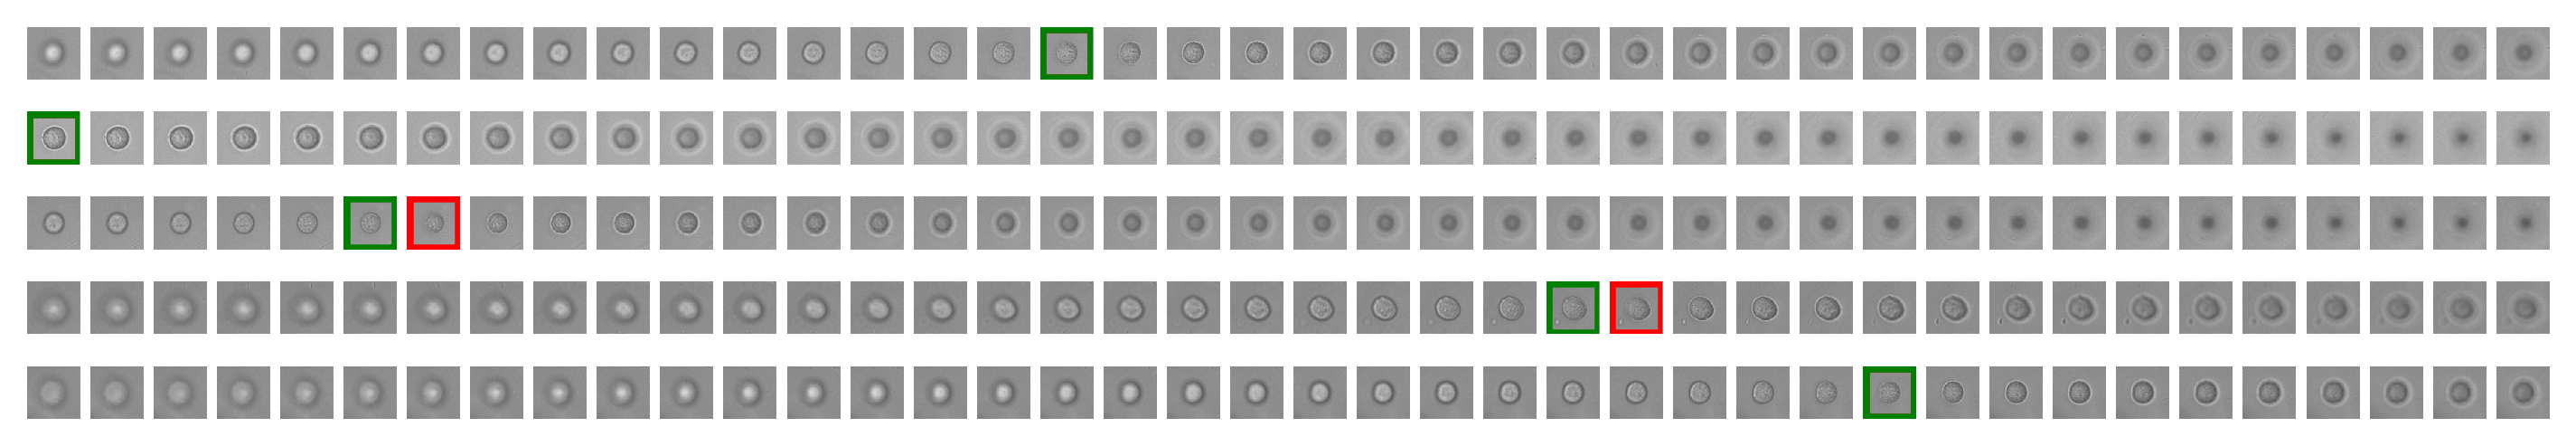

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
dataP = data[::1]
#fig = plt.figure()
fig, axes = plt.subplots(ncols=dataP.shape[0], nrows=dataP.shape[1], figsize=(12,2), dpi=300)
axes = np.array(axes).reshape((dataP.shape[1], dataP.shape[0])).T
for i in range(dataP.shape[1]):
    for j in range(dataP.shape[0]):
        #ax = plt.subplot(data.shape[1]//4, data.shape[0], i*data.shape[0]+j+1)
        #ax.imshow(data[j,i])
        ax =axes[j][i]
        ax.imshow(dataP[j,i], vmin=0, vmax=255, cmap="Greys_r")
        ax.axis("off")
for i,p in enumerate(positions[:,2]):
    ax = axes[int(p),i]
    rect = Rectangle((0,0), 100, 100, edgecolor="r", linewidth=3, facecolor="none")
    ax.add_patch(rect)
positionsST = np.argmax(predictions.mean((2,3)), axis=0)
for i,p in enumerate(positionsST):
    ax = axes[int(p),i]
    rect = Rectangle((0,0), 100, 100, edgecolor="g", linewidth=3, facecolor="none")
    ax.add_patch(rect)
#plt.savefig("cellFocusInput.png")

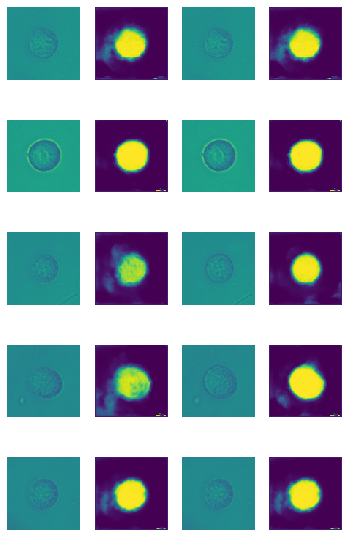

In [9]:
dataGT = data[::1]
dataST = predictions[::1]
#fig = plt.figure()
fig, axes = plt.subplots(nrows=dataP.shape[1], ncols=4, figsize=(6,10))
axes = np.array(axes).reshape((dataP.shape[1],4))
positionsST = np.argmax(predictions.mean((2,3)), axis=0)
for i in range(dataP.shape[1]):
    pGT = int(positions[i,2])
    pST = positionsST[i]
    ax = axes[i][0]
    ax.imshow(dataGT[pGT,i], vmin=0, vmax=255)
    ax.axis("off")
    ax = axes[i][1]
    ax.imshow(dataST[pGT,i], vmin=0, vmax=1)
    ax.axis("off")
    ax = axes[i][2]
    ax.imshow(dataGT[pST,i], vmin=0, vmax=255)
    ax.axis("off")
    ax = axes[i][3]
    ax.imshow(dataST[pST,i], vmin=0, vmax=1)
    ax.axis("off")

## Canny edge detection

In [10]:
from skimage import feature
from skimage.filters import gaussian
from scipy.ndimage import morphology
from skimage.measure import label, regionprops
struct = morphology.generate_binary_structure(2, 1)  #structural element for binary erosion


In [11]:
dataN = (data-data.mean((2,3))[:,:,None,None])/data.std((2,3))[:,:,None,None]
predictions = []
for d in dataN.reshape((-1, 100,100)):
    im1o = feature.canny(d, sigma=2.5, low_threshold=0.6, high_threshold=0.99, use_quantiles=True) #edge detection           
    im2o = morphology.binary_fill_holes(im1o, structure=struct).astype(int) #fill holes
    im3o = morphology.binary_erosion(im2o, structure=struct).astype(int) #erode to remove lines and small dirt   
    predictions.append(im3o)
predictions=np.array(predictions).squeeze().reshape((40,5,100,100))
predictions.shape

(40, 5, 100, 100)

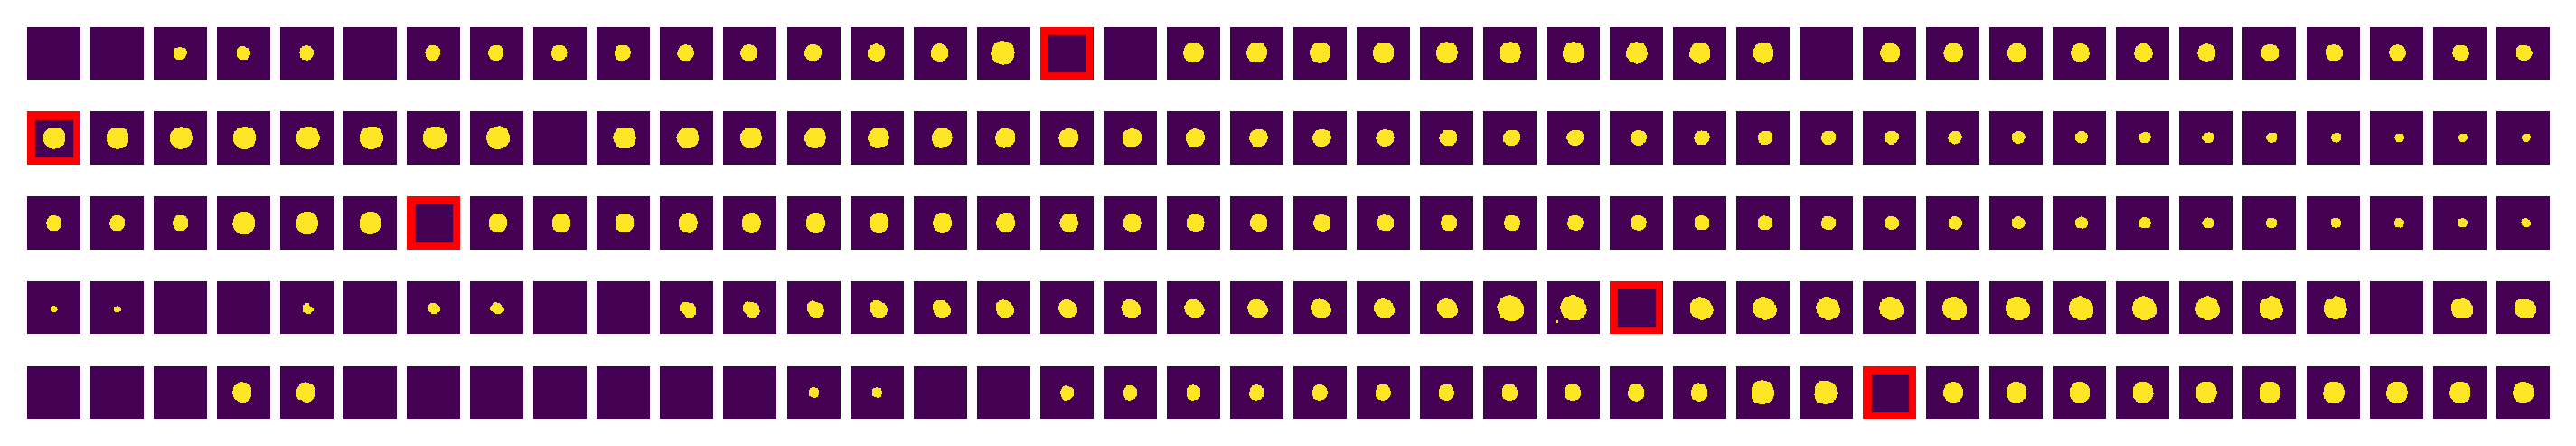

In [12]:
import matplotlib.pyplot as plt
dataP = predictions[::1]
#fig = plt.figure()
fig, axes = plt.subplots(ncols=dataP.shape[0], nrows=dataP.shape[1], figsize=(12,2), dpi=300)
axes = np.array(axes).reshape((dataP.shape[1], dataP.shape[0])).T
for i in range(dataP.shape[1]):
    for j in range(dataP.shape[0]):
        #ax = plt.subplot(data.shape[1]//4, data.shape[0], i*data.shape[0]+j+1)
        #ax.imshow(data[j,i])
        ax =axes[j][i]
        ax.imshow(dataP[j,i]>0.5, vmin=0, vmax=1)
        ax.axis("off")
for i,p in enumerate(positions[:,2]):
    ax = axes[int(p),i]
    rect = Rectangle((0,0), 100, 100, edgecolor="r", linewidth=4, facecolor="none")
    ax.add_patch(rect)
positionsST = np.argmax(predictions.mean((2,3)), axis=0)
plt.savefig("cellFocusPrediction_Canny.png")

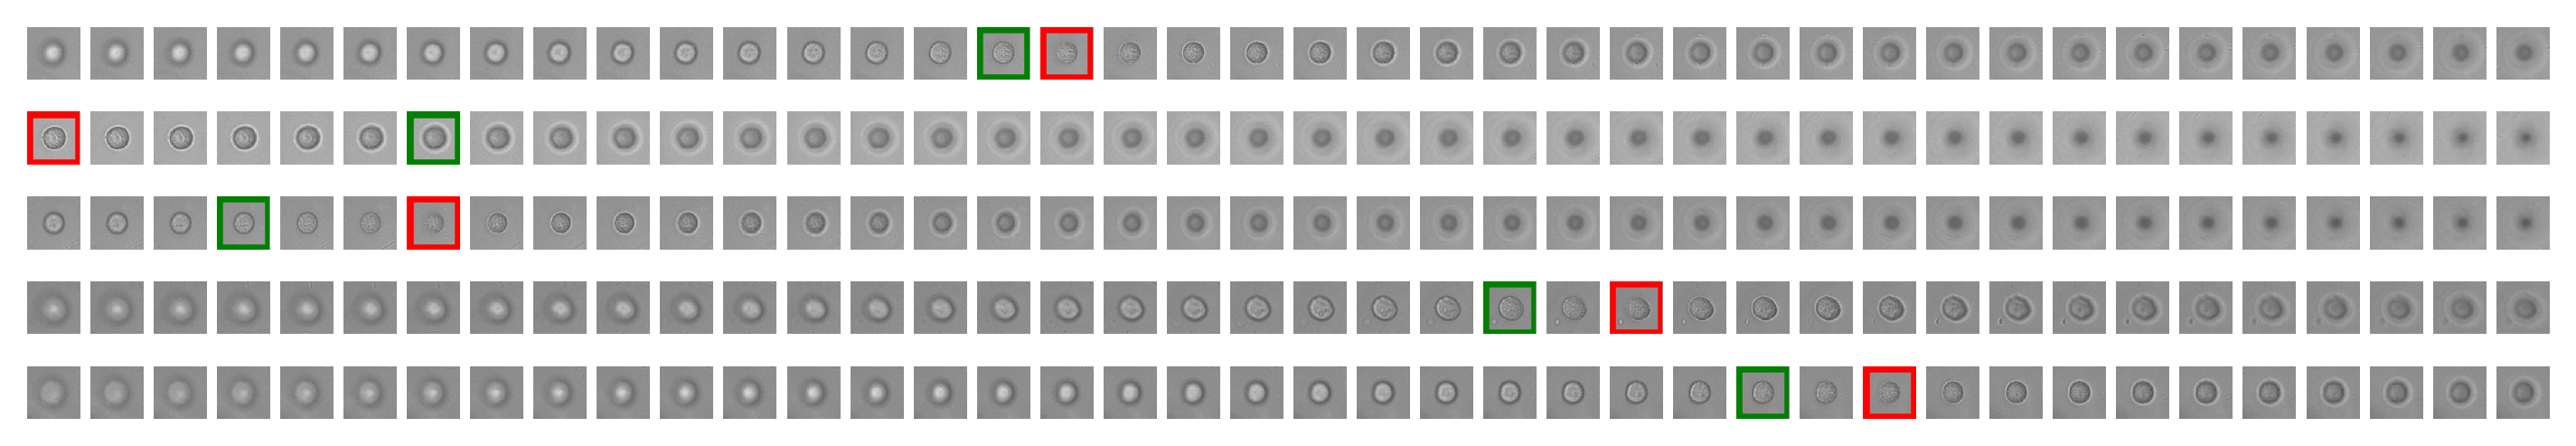

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
dataP = data[::1]
#fig = plt.figure()
fig, axes = plt.subplots(ncols=dataP.shape[0], nrows=dataP.shape[1], figsize=(12,2), dpi=300)
axes = np.array(axes).reshape((dataP.shape[1], dataP.shape[0])).T
for i in range(dataP.shape[1]):
    for j in range(dataP.shape[0]):
        #ax = plt.subplot(data.shape[1]//4, data.shape[0], i*data.shape[0]+j+1)
        #ax.imshow(data[j,i])
        ax =axes[j][i]
        ax.imshow(dataP[j,i], vmin=0, vmax=255, cmap="Greys_r")
        ax.axis("off")
for i,p in enumerate(positions[:,2]):
    ax = axes[int(p),i]
    rect = Rectangle((0,0), 100, 100, edgecolor="r", linewidth=3, facecolor="none")
    ax.add_patch(rect)
positionsST = np.argmax(predictions.mean((2,3)), axis=0)
for i,p in enumerate(positionsST):
    ax = axes[int(p),i]
    rect = Rectangle((0,0), 100, 100, edgecolor="g", linewidth=3, facecolor="none")
    ax.add_patch(rect)
#plt.savefig("cellFocusInput_Canny.png")

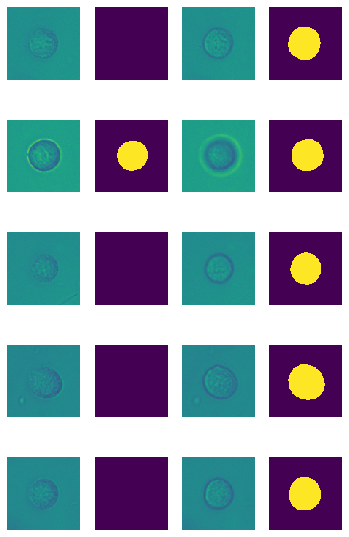

In [14]:
dataGT = data[::1]
dataST = predictions[::1]
#fig = plt.figure()
fig, axes = plt.subplots(nrows=dataP.shape[1], ncols=4, figsize=(6,10))
axes = np.array(axes).reshape((dataP.shape[1],4))
positionsST = np.argmax(predictions.mean((2,3)), axis=0)
for i in range(dataP.shape[1]):
    pGT = int(positions[i,2])
    pST = positionsST[i]
    ax = axes[i][0]
    ax.imshow(dataGT[pGT,i], vmin=0, vmax=255)
    ax.axis("off")
    ax = axes[i][1]
    ax.imshow(dataST[pGT,i], vmin=0, vmax=1)
    ax.axis("off")
    ax = axes[i][2]
    ax.imshow(dataGT[pST,i], vmin=0, vmax=255)
    ax.axis("off")
    ax = axes[i][3]
    ax.imshow(dataST[pST,i], vmin=0, vmax=1)
    ax.axis("off")